In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
tf.__version__

'2.12.0'

# Preprocessing

In [76]:
styleTransferModel = tf.keras.applications.VGG19(
    include_top=False, # For no classification
    weights="imagenet", # Database
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [77]:
styleTransferModel.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [78]:
print("Layers:" + str(len(styleTransferModel.layers)))

Layers:22


## Image Reference

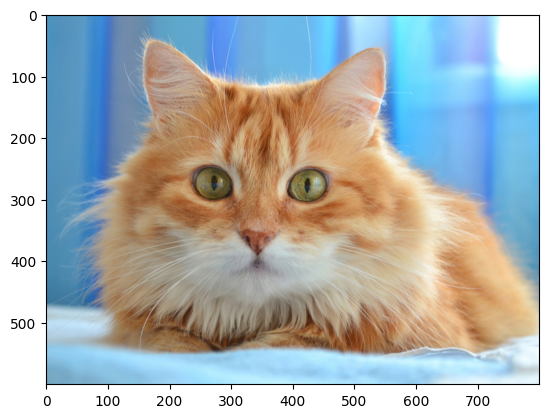

In [79]:
chaves = tf.keras.preprocessing.image.load_img("Gato Angora - shutterstock.jpg")
plt.imshow(chaves)

In [80]:
type(chaves)

PIL.JpegImagePlugin.JpegImageFile

In [81]:
chaves = tf.keras.preprocessing.image.img_to_array(chaves)
type(chaves)

numpy.ndarray

In [82]:
# 0 - 255
chaves.min(), chaves.max()

(0.0, 255.0)

In [83]:
# Normalizando entre 0 e 1
# 0 - 1
chaves = chaves/255
chaves.min(), chaves.max()

(0.0, 1.0)

In [84]:
chaves = chaves[tf.newaxis, :]

In [85]:
chaves.shape

(1, 600, 800, 3)

## Style Image

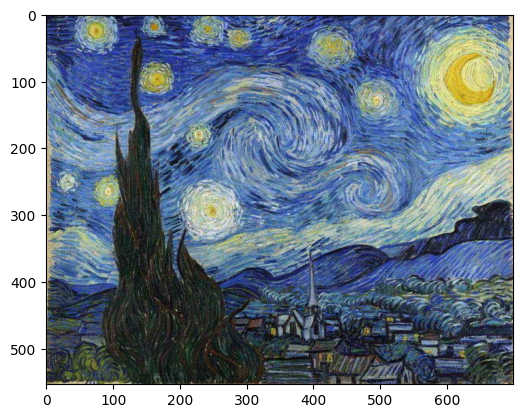

In [86]:
style_image = tf.keras.preprocessing.image.load_img("van-gogh-noite-estrelada-d (1).jpg")
plt.imshow(style_image)

In [87]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image/255
style_image = style_image[tf.newaxis, :]
style_image.shape

(1, 554, 700, 3)

# VGG19 Convolutional Neural Network

In [88]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1', 'block5_conv1' ]

In [89]:
len_content_layers = len(content_layers)
len_style_layers = len(style_layers)
len_content_layers, len_style_layers

(1, 5)

In [90]:
# Cria uma nova rede neural a partir da rede neural VGG com as camadas de saída
def vgg_layer (layer_name):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_name]
    neuralnet = tf.keras.Model(inputs = [vgg.input], outputs = outputs)
    return neuralnet

In [91]:
style_extractor = vgg_layer(style_layers)

In [92]:
style_extractor.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [93]:
style_extractor.outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [94]:
outputs_style = style_extractor(style_image)

In [95]:
outputs_style[0].shape

TensorShape([1, 554, 700, 64])

In [96]:
def gram_matrix (activations_values):
    result =  tf.linalg.einsum('bijc,bijd->bcd', activations_values, activations_values)
    input_shape = tf.shape(activations_values)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result/num_locations

In [97]:
gram_matrix(outputs_style[0])

<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[0.6242284 , 0.11009218, 0.17069855, ..., 0.15496631,
         0.35965115, 0.44888204],
        [0.11009218, 0.05078019, 0.05440161, ..., 0.02061801,
         0.07506765, 0.08849922],
        [0.17069855, 0.05440161, 0.07172972, ..., 0.02388142,
         0.11750739, 0.14296122],
        ...,
        [0.15496631, 0.02061801, 0.02388142, ..., 0.12486746,
         0.10173342, 0.10197654],
        [0.35965115, 0.07506765, 0.11750739, ..., 0.10173342,
         0.28017268, 0.31646326],
        [0.44888204, 0.08849922, 0.14296122, ..., 0.10197654,
         0.31646326, 0.37605405]]], dtype=float32)>

In [98]:
class StyleContentModel (tf.keras.models.Model):
    def __init__(self, outputs_styles, content_layers):
        super().__init__()
        self.vgg = vgg_layer(outputs_styles + content_layers)
        self.style_layers = outputs_styles
        self.content_layers = content_layers
        self.len_content_layers = len(content_layers)
        self.len_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self,image):
        image = image * 255.0
        image_preprocess = tf.keras.applications.vgg19.preprocess_input(image)
        outputs = self.vgg(image_preprocess)
        style_output = outputs[:self.len_style_layers] # 0 to 4
        content_output = outputs[self.len_content_layers:] # 5 to End

        style_output = [gram_matrix(layer) for layer in style_output]

        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_output)}
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_output)}

        return {'content': content_dict,'style':style_dict}

In [99]:
extractor = StyleContentModel(style_layers, content_layers)

In [100]:
results = extractor(style_image)

In [101]:
results

{'content': {'block4_conv2': <tf.Tensor: shape=(1, 277, 350, 128), dtype=float32, numpy=
  array([[[[   0.       ,    0.       ,  164.61818  , ...,  503.92807  ,
               0.       ,  982.2459   ],
           [   0.       ,    0.       ,   83.68065  , ...,   76.0631   ,
               0.       ,    0.       ],
           [   0.       ,    0.       ,    0.       , ...,  208.86534  ,
               0.       ,   47.913548 ],
           ...,
           [   0.       ,    0.       ,  347.71835  , ...,  100.39979  ,
               0.       ,    0.       ],
           [   0.       ,    0.       ,  197.09395  , ...,  187.44614  ,
               0.       ,   36.655678 ],
           [   0.       ,    0.       ,  473.72974  , ...,  718.6081   ,
               0.       ,    0.       ]],
  
          [[   0.       ,    0.       ,  157.78105  , ...,  388.1733   ,
               0.       , 1153.7605   ],
           [   0.       ,    0.       ,    0.       , ...,  183.7567   ,
             302.284

In [102]:
for key,value in results.items():
    print(key,value.keys())

content dict_keys(['block4_conv2'])
style dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [103]:
style = extractor(style_image)['style']
content = extractor(chaves)['content']

In [104]:
style

{'block1_conv1': <tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
 array([[[ 3026.1765  ,  1624.5332  ,   830.69104 , ...,  1497.2623  ,
            709.59    ,  1029.3324  ],
         [ 1624.5332  ,  4369.8564  ,  1519.4125  , ...,  1045.1123  ,
           1126.9198  ,   909.46246 ],
         [  830.69104 ,  1519.4125  ,   911.29407 , ...,    97.078575,
            642.00946 ,   714.19617 ],
         ...,
         [ 1497.2623  ,  1045.1123  ,    97.078575, ..., 10469.362   ,
            982.8545  ,   426.06116 ],
         [  709.59    ,  1126.9198  ,   642.00946 , ...,   982.8545  ,
           1360.6995  ,  1020.5233  ],
         [ 1029.3324  ,   909.46246 ,   714.19617 , ...,   426.06116 ,
           1020.5233  ,  1113.7786  ]]], dtype=float32)>,
 'block2_conv1': <tf.Tensor: shape=(1, 128, 128), dtype=float32, numpy=
 array([[[6.8458916e+01, 2.1882069e+01, 1.4747872e+00, ...,
          1.5462656e+02, 5.2642544e+01, 4.4764935e+01],
         [2.1882069e+01, 2.6973727e+04, 9.3717607

In [105]:
len(style), len(content)

(5, 1)

In [106]:
image_result = tf.Variable(chaves)

In [107]:
content_weight = 1
style_weight = 100000

In [108]:
optimizer = tf.optimizers.Adam(learning_rate=0.02)

## Training

Epoch: 500 Content Loss tf.Tensor(35615.566, shape=(), dtype=float32) Style loss tf.Tensor(61415336.0, shape=(), dtype=float32) Total loss tf.Tensor(1228306800000.0, shape=(), dtype=float32)


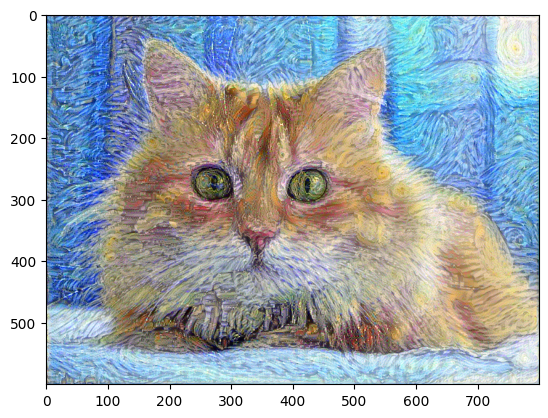

Epoch: 1000 Content Loss tf.Tensor(36919.633, shape=(), dtype=float32) Style loss tf.Tensor(39250484.0, shape=(), dtype=float32) Total loss tf.Tensor(785009740000.0, shape=(), dtype=float32)


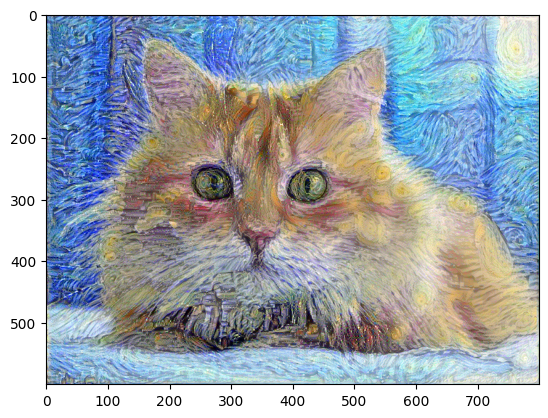

In [109]:
epochs = 1000
impress = 500

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        outputs = extractor(image_result)

        outputs_content = outputs['content']
        outputs_style = outputs['style']

        content_loss = tf.add_n([tf.reduce_mean((outputs_content[name] - content[name]) ** 2) for name in outputs_content.keys()])
        style_loss = tf.add_n([tf.reduce_mean((outputs_style[name] - style[name]) ** 2) for name in outputs_style.keys()])

        total_loss = (content_loss*content_weight)/len_content_layers + (style_loss*style_weight)/len_style_layers

    gradient = tape.gradient(total_loss, image_result)
    optimizer.apply_gradients([(gradient, image_result)])
    image_result.assign(tf.clip_by_value(image_result, 0.0, 1.0))


    if((epoch + 1) % impress == 0):
        print('Epoch:', epoch+1, 'Content Loss', content_loss, 'Style loss', style_loss, 'Total loss', total_loss)
        plt.imshow(tf.squeeze(image_result, axis=0))
        plt.show()


## Results

In [110]:
figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,8))
ax1.imshow(tf.squeeze(chaves, axis = 0))
plt.axis('off')
ax2.imshow(tf.squeeze(style_image, axis = 0))
plt.axis('off')
ax3.imshow(tf.squeeze(image_result, axis = 0))
plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.